<a id='zero'></a>
## 0. Introduction

This tutorial introduces the reader to the NetworkX library and its applications in Data Science. Since a lot of real-world data can be modeled using graphs, NetworkX is a powerful tool which lets the user handle the data in an organized manner and also execute useful algorithms on the data. This tutorial assumes that the reader is already familiar with the basics of graph theory and some graph algorithms such as the Dijkstra's shortest path Algorithm and the Girvan-Newman algorithm for detecting communities in a graph. If you are not familiar with these or are completely new to working with NetworkX, it is highly recommended that you go through these notes: http://www.datasciencecourse.org/notes/graphs/.

In order to demonstrate how NetworkX can be used in practice, we will be going through an example of how the library can be used to analyze information. After all, one of the best ways to learn a concept in data science is with the help of an example. It is pretty conventional to run graph analytics on social networks like Facebook, Twitter, Instagram etc., but today we will be analyzing the greatest social network of all: Github. We will be extracting information from the Github GraphQL library: the Github API which stores information about different repositories and users on Github. But before we delve into the example, we will first go over a few notions of "centrality" in graphs in order to better understand graphical data. 

## Table of Contents
1. [Sample graphs and visualization in NetworkX](#one)
2. [Graph Operations](#oneone)
3. [Centrality](#two)
4. [Github GraphQL API v4](#three)
    - [Authentication](#three1)
    - [Querying](#three2)
    - [Pagination](#three3)
    - [Obtaining Followers](#three4)
5. [Creating the Github Graph](#four)
6. [Analyzing the Github Graph](#five)
    - [Centrality Measures](#five1)
    - [Visualization](#five2)
7. [Conclusions](#six)
8. [Further Reading and Resources](#last)

In [130]:
# Importing all the necessary libraries for the tutorial
import requests
import json
import networkx as nx

<a id='one'></a>
## 1. Sample graphs and visualization in NetworkX

NetworkX has a huge library of sample graphs that we can use to understand different algorithms and definitions in graph theory. For example, the following code generates the Petersen graph, a classic graph which can act as a counterexample to many promising propositions in graph theory. We create a new Petersen Graph by using the graph generator function `petersen_graph`.

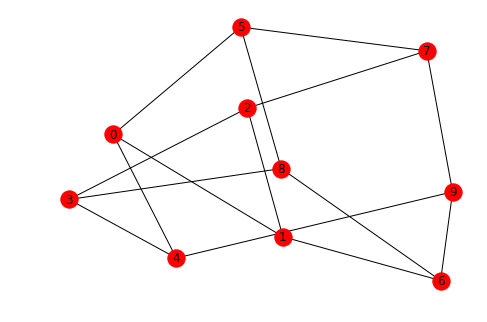

In [69]:
petersen = nx.petersen_graph()
nx.draw(petersen, with_labels=True)
# The reader is encouraged to run this cell repeatedly and see the output

Wait, that doesn't look like the Petersen graph. This is because in the back-end, NetworkX only stores the nodes and the edges between different nodes. There is no fixed 'spacial orientation' of the nodes in a networkX graph. Therefore, if the `draw` function is called on the graph again and again, we will always get different orientations of the same graph. In order to have a fixed orientation we must use something else. `draw_shell` is one such a function which lets us draw the nodes in the form of concentric circles with an `nlist` parameter. The parameter takes in a list of lists and each list contains the labels of the nodes in one circle. 

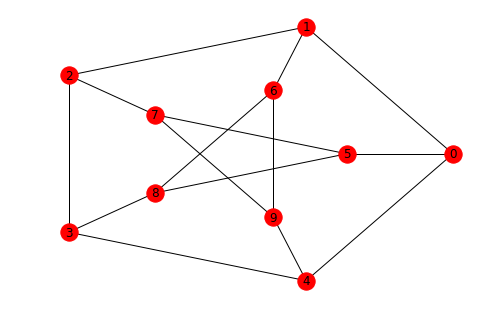

In [39]:
nx.draw_shell(petersen, nlist=[range(5,10), range(5)], with_labels=True)

Much better! There are other functions such as `draw_circular` and `draw_spring` which let us visualize graphs in different orientations. The reader is encouraged to look up the NetworkX documentation and see what all options the library provides for visualization since it is a key part of analyzing data. It would have been very difficult to observe properties of the Petersen graph from the previous orientation, but now it is easy to see that it is 3-regular (all nodes have 3 edges), and has a symmetric structure. A resource is listed in the further reading section (at the end of this tutorial), which introduces the reader to other methods of visualizing graphs using NetworkX.

<a id='oneone'></a>
## 2. Graph Operations

NetworkX has a rich collection of functions which let us perform operations on graphs such `union`, `complement`, `subgraph` and many more. Let's see a few examples: 

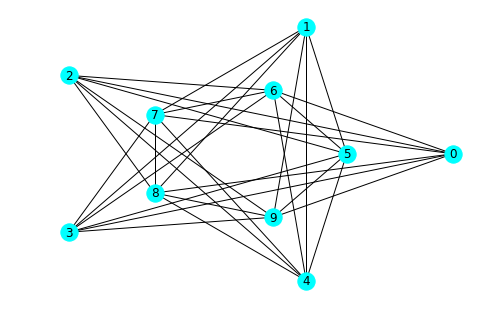

In [291]:
c_petersen = nx.complement(petersen)
nx.draw_shell(c_petersen, nlist=[range(5,10), range(5)], with_labels=True, node_color='#00FFFF')

As expected, the `complement` function removes all the edges from the graph and adds all the edges that were not present in the graph. 

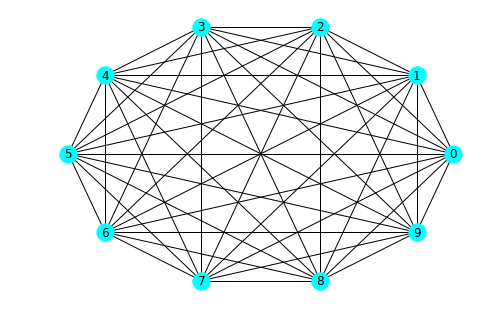

In [290]:
k10 = nx.compose(petersen, c_petersen)
nx.draw_circular(k10, with_labels=True, node_color='#00FFFF')

`compose` is an especially useful function because it identifies the common nodes in two graphs and then outputs the resulting graph.

There are other really useful graph operations such as well and the reader is encouraged to read the follow-up tutorial on graph operations in the [Further Reading and Resources](#last) and try them all. We will be using `subgraph` later on in the tutorial when we are analyzing the Github graph.

<a id='two'></a>
## 3. Centrality 

Indicators of centrality help identify the most 'important' nodes in a graph. They were developed to identify the most influential people in a social network and before we analyze the Github network we must familiarize with a few measures of centrality. One graph that can be used to study different notions of centrality is the Krackhardt Kite Graph. Again, it can be easily generated in NetworkX and then visualized. 

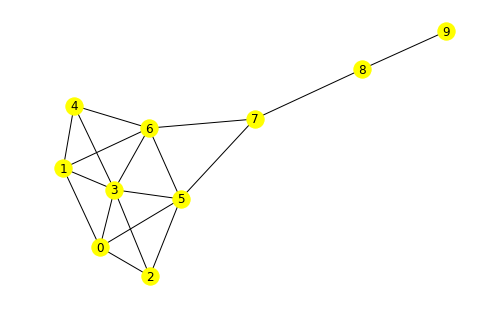

In [273]:
kite = nx.generators.small.krackhardt_kite_graph()
nx.draw_spring(kite, with_labels=True, node_color='yellow') 
# draw_spring is suitable for visualizing the Krackhardt Kite Graph

Now, the above graph is useful for demonstrating the differences between the following measures of centrality:

-  Degree Centrality: The number of incident edges on the node.
-  Closeness Centrality: Measure of how 'close' a node is to other nodes in the graph. The shorter the shortest paths to other nodes, the greater a node's closeness centrality.
-  Betweenness Centrality: Measure of how often the node is on the path between any two nodes in a graph. A node will have betweenness centrality if there are several pairs of nodes whose path necessarily goes through that node. 

We will now calculate the degree, closeness and betweenness centrality of the Kite graph. Again, we have a few NetworkX functions to help us. 

In [254]:
# Degree Centrality
print(sorted(nx.degree_centrality(kite).items(), key=lambda x: x[1]))
# We can see that node 3 has the highest degree centrality since it is 
# directly connected to the most number of nodes. 

[(9, 0.1111111111111111), (8, 0.2222222222222222), (2, 0.3333333333333333), (4, 0.3333333333333333), (7, 0.3333333333333333), (0, 0.4444444444444444), (1, 0.4444444444444444), (5, 0.5555555555555556), (6, 0.5555555555555556), (3, 0.6666666666666666)]


In [255]:
# Degree Centrality
print(sorted(nx.closeness_centrality(kite).items(), key=lambda x: x[1]))
# We can see that node 5, 6 have the highest closeness centrality. This 
# makes sense as they are in the center of the graph 'visually'.

[(9, 0.3103448275862069), (8, 0.42857142857142855), (2, 0.5), (4, 0.5), (0, 0.5294117647058824), (1, 0.5294117647058824), (3, 0.6), (7, 0.6), (5, 0.6428571428571429), (6, 0.6428571428571429)]


In [256]:
# Betweenness Centrality
print(sorted(nx.betweenness_centrality(kite).items(), key=lambda x: x[1]))
# We can see that node 7 has the highest betweenness centrality. This
# makes sense as any path from node 8,9 to any other node to the left of
# node 7 will have node 7 in it.

[(2, 0.0), (4, 0.0), (9, 0.0), (0, 0.023148148148148143), (1, 0.023148148148148143), (3, 0.10185185185185183), (8, 0.2222222222222222), (5, 0.23148148148148148), (6, 0.23148148148148148), (7, 0.38888888888888884)]


Let's say we are given a graph of America, where the nodes are cities and the edges are highways connecting the cities. Degree centrality will help us obtain the 'biggest cities', that is, the cities directly connected to most other cities (such as New York or Los Angeles). Closeness centrality will help us obtain the geographical center of the country (some city in Kansas). And betweenness centrality will try to capture a little bit of both: a city which acts like an important pivot for many paths in the graph, but is still close to the geographical center of the country. Betweenness centrality has a lot of significance in identifying communities in social networks (as you would know from the Girvan-Newman algorithm). The reader is encouraged to read about other measures of centrality (resource listed in further readings). 

Now that we understand how to visualize graphs in NetworkX and have an intuitive understanding of different measures of centrality, we can dive into our example: analyzing Github networks using the GraphQL Library!

<a id='three'></a>
## 4. GraphQL API v4

The Github GraphQL API v4 is an API which lets the client obtain information about different repositories and users in the Github "social network". Interestingly, the API itself has been implemented as a graph where the nodes are objects such as repositories, languages, users etc, and the edges are relationships between objects such as the contributors of a repository, the followers of a user etc. The complete set of possible data that the client can access (such as objects and relationships) is described by the Schema of the API, which defines its type system. 

In this tutorial, we want to demonstrate the importance of different measures of centrality in a social network. The network that we will obtain and then work with will be created as follows:

- Pick a repository. We will be choosing the NetworkX Github repository itself (because why not). 
- Obtain the users who have starred the repository.
- Obtain the followers of all the users. 
- Add edges between the user and the follower if the follower is already a part of our vertex set (the follower has also starred the NetworkX repository).

Note that the graph we obtain here is not a bi-directional 'friend' graph. It is an interest graph, in the sense that the edges are directed from the 'interested' object to the 'interesting' object. We could make an undirected graph too, but that way we will lose some valuable information (because following a lot of users is very different from being followed by a lot of users). 

<a id='three1'></a>
### 4.1 Authentication

Like many APIs, the GraphQL library also uses OAuth tokens to authorize its API usage. In order to obtain your own personal access token, follow the instructions on this page: https://help.github.com/articles/creating-a-personal-access-token-for-the-command-line/.

Now, once you have your own token, we can begin! We will be using the Python Requests library to send queries to the API and retrieve information. If you are not familiar with the requests library, it is highly recommended you read this very helpful primer: http://www.pythonforbeginners.com/requests/using-requests-in-python

Note that the GraphQL library only has one URL endpoint, that is, no matter what kind of information we want to retrieve, we can access it from the same URL (really convenient, if you ask me). 

In [253]:
token = "dff7358eaffb0d40d892924cfdf9fa058324f50b" # Enter your generated token
headers = {"Authorization": 'token ' + token} 
url = "https://api.github.com/graphql" # API endpoint

empty_query = ""

response_try = requests.post(url=url, json={'query': empty_query}, headers=headers)
print(response_try.status_code) # Should give 200 if successful

200


Yay it works! But we haven't actually queried anything yet, so we don't really have anything right now. Queries in the GraphQL library are organized in a pretty special way and now we will see how to create one.

<a id='three2'></a>
### 4.2 Querying

We need to first obtain the users who have starred the NetworkX repository. In order to do that, we will create the following query:

In [257]:
get_stargazers = '''query {
  repository(owner:"networkx", name:"networkx") {
        stargazers(first:100){
            edges {
                cursor
                node {
                    login
                }
            }
        }
    }
}'''

Let's try to understand the above query line by line:
-  Every query starts off with the `query` keyword.
-  Next, we need a `repository` object. In order to specify which repository we need, we need to specify the `owner` and `name` arguments. 
-  Now, we need the `stargazers` of the repository. Again, we need to specify an argument for how many stargazers we need. This `stargazer` connection returns a list of `edges`.
-  Now, we need to traverse each of these `edges`. 
-  For each edge, we obtain a cursor (more on that later, see [Pagination](#three3)) and the node (which is a user) connected to the edge. 
-  Then we obtain the login ID of each of these users. 

This way of querying may seem funky, but once you get used to it, it is really intuitive. 

In [258]:
stargazers = []

stargazers_req = requests.post(url=url, json={'query': get_stargazers}, headers=headers)
stargazers_req = stargazers_req.json()

for i in range(len(stargazers_req['data']['repository']['stargazers']['edges'])):
    stargazers.append(stargazers_req['data']['repository']['stargazers']['edges'][i]['node']['login'])

So with that one simple (ok maybe not simple, but elegant at least) query, we obtain 100 of the stargazers of the NetworkX repository! If you want to test out your queries, Github GraphQL provides you with an explorer which lets you run queries without any overheard code. (See [Further Readings and Resources](#last))

In [259]:
print(len(stargazers))
print(stargazers)

100
['hownowstephen', 'marcinpohl', 'rfugger', 'evandeaubl', 'kmelnikov', 'winterstream', 'eman', 'yy', 'georgkreimer', 'jamesonwatts', 'gazoombo', 'jovo', 'rutsky', 'westurner', 'igormilovanovic', 'oberhamsi', 'fperez', 'matagus', 'yaph', 'aaronmcdaid', 'carltongibson', 'CNBorn', 'ravipudi', 'nkhine', 'ido', 'bwreilly', 'spenthil', 'Sedward', 'ccarpenterg', 'redaready', 'khughitt', 'mahmoud', 'bcroq', 'uruz', 'alexland', 'Midnighter', 'bcambel', 'fabiencastan', 'adwaraki', 'foamdino', 'pexnet', 'jgmize', 'stesh', 'hagberg', 'wmark', 'olivierverdier', 'twu', 'stefanzweig', 'talesp', 'ammonite', 'pmarshwx', 'conradlee', 'mpuig', 'adrianN', 'Rafiot', 'yasuharu519', 'davidandrzej', 'djv', 'invisibleroads', 'pmangg', 'geier', 'jwistaria', 'mshelton', 'jseabold', 'mrocklin', 'shreyu86', 'erictheise', 'gawbul', 'rsgalloway', 'chebee7i', 'Julian', 'dliverman', 'sandrotosi', 'liangxiao', 'seansay', 'greeness', 'motiteux', 'joke2k', 'mtakemiya', 'thePastor', 'ChrisOelmueller', 'nkvoll', 'bagrow

<a id='three3'></a>
### 4.3 Pagination

You might have noticed that we only took the first 100 stargazers of the repository, even though the repository actually has over 4000 stargazers. We did this because we actually cannot get more than 100 results per query anyway because the GraphQL library has a node limit of 100. However, in order to get a substantial amount of data, we need more nodes! A way to tackle this problem is by using pagination. 

An important object inside every edge is the `cursor`. The cursor defines an ID which lets us access the first 100 stargazers offset by a certain amount. Once we have the `cursor` for every edge, we can use the `after` argument while calling the Stargazers connection in order to get the next 100 stargazers. So our code now becomes:

In [261]:
for i in range(5):
    cursor = stargazers_req['data']['repository']['stargazers']['edges'][99]['cursor']
    new_query = '''query {
      repository(owner:"networkx", name:"networkx") {
            stargazers(first:100, after:"''' + cursor + '''"){
                edges {
                    cursor
                    node {
                        login
                    }
                }
            }
        }
    }'''

    stargazers_req = requests.post(url=url, json={'query': new_query}, headers=headers)
    stargazers_req = stargazers_req.json()

    for j in range(len(stargazers_req['data']['repository']['stargazers']['edges'])):
        stargazers.append(stargazers_req['data']['repository']['stargazers']['edges'][j]['node']['login'])

In [264]:
print(len(stargazers))
print(stargazers[550:])

600
['gulyasm', 'ajaykgp', 'jstolle', 'mikeboers', 'guneysus', 'DenXX', 'pablormier', 'while0pass', 'ssahu', 'attomsoft', 'abudulemusa', 'etng', 'Overv', 'wfwei', 'akashin', 'flaub', 'marcoalacot', 'arnaldorusso', 'svaksha', 'lufenghuan', 'tndoan', 'eglassman', 'wuschel', 'dastergon', 'hjs', 'vonmoltke', 'revivo', 'jeffchan', 'the-machinist', 'tomkap', 'GMD1987', 'ifmihai', 'paulokopny', 'neopunisher', 'emorikawa', 'TsaiJin', 'kafle', 'laike9m', 'flynnwang', 'PekkaLehtonen', 'ixaxaar', 'outformatics', 'kaustubhn', 'pieterswart', 'oss6', 'brifordwylie', 'sefakilic', 'fjyuu', 'jcfoxgrover', 'degiere']


Great, it works! We now have 600 stargazers, and we can finally move on to obtaining the stargazers' followers. 

<a id='#three3'></a>
### 4.4 Obtaining Followers

Now in order to extend the graph and observe relationships between users, we will retrieve the followers of the 600 stargazers. Note that we will not paginate here and assume that all the users have 100 or fewer followers.

In [265]:
# Running this cell takes quite a while, since we are making 600 calls to the API

followers = {}

for i in range(600):
    get_followers = '''query{
        user(login: "''' + stargazers[i] + '''") {
            followers(first:100){
                edges {
                    node {
                        login
                    }
                }
            }
        }
    }'''
    
    followers_req = requests.post(url=url, json={'query': get_followers}, headers=headers)
    followers_req = followers_req.json()
    followers_tmp = []
    
    for j in range(len(followers_req['data']['user']['followers']['edges'])):
        followers_tmp.append(followers_req['data']['user']['followers']['edges'][j]['node']['login'])
    
    followers[stargazers[i]] = followers_tmp
    
print(len(followers))

600


Note that the only difference from the previous query is that we get the `user` object and then we call the `followers` connection. No matter what kind of information one needs, the structure of the query remains pretty much the same, and that is the power of representing an API as a graph. 

Now that we have all our data, we can finally move on to constructing the graph in NetworkX!

<a id='four'></a>
## 5. Creating the Github Graph

We will begin by initializing an empty directed graph and then adding all the user nodes along with their edge to the repository. 

In [193]:
g = nx.DiGraph()
g.add_node('networkx', type='repo')

for sg in stargazers:
    g.add_node(sg, type='user')
    g.add_edge(sg, 'networkx', type='gazes')

print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 601
Number of edges: 600
Average in degree:   0.9983
Average out degree:   0.9983


As we expected, we now have a tree (a star graph in particular), with all edges pointing to the repository. Let's add the follower edges.

In [194]:
for sg in followers:
    for f in followers[sg]:
        if f in g: # only add an edge if the node already exists 
            g.add_edge(f, sg, type='follows')
            
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 601
Number of edges: 858
Average in degree:   1.4276
Average out degree:   1.4276


<a id='five'></a>
## 6. Analyzing the Github Graph
To begin with, let's see which nodes have the highest degree.

In [199]:
print (sorted(g.degree(), key=lambda x: x[1], reverse=True)[:20])

[('networkx', 600), ('JT5D', 33), ('matagus', 21), ('adulau', 16), ('djv', 14), ('CNBorn', 10), ('alexband', 10), ('ptwobrussell', 10), ('yy', 9), ('hagberg', 9), ('gawbul', 9), ('clvrobj', 9), ('seansay', 8), ('bagrow', 8), ('jovo', 7), ('fperez', 7), ('dschult', 7), ('sballesteros', 7), ('esafak', 7), ('yaph', 6)]


This seems fishy. The main contributor to the repository, `hagberg` has a relatively small degree as compared to some other users. Does this mean that the other users are more 'important' than `hagberg` in this network? Absolutely not! If we actually see the indegree and the outdegree, we note that `hagberg` is actually followed by a lot of users whereas users like `JT5D` are not. 

In [267]:
print (len(g.out_edges('JT5D')))
print (len(g.in_edges('JT5D')))
print (len(g.out_edges('hagberg')))
print (len(g.in_edges('hagberg')))

33
0
1
8


<a id='five1'></a>
### 6.1 Centrality Measures
Thus, we see that we need other notions of 'node importance' to better study graphs. This is where centrality comes in and why it is so important. Before applying the measures of centrality, we will first modify the graph to remove extraneous nodes and edges using the graph operation `subgraph` (the `nbunch` argument takes in the list of nodes to be retained). Particularly, the repository node and the edges connected to it. 

In [293]:
users = []
for n in g:
    if g.node[n]['type'] == 'user': # This is why we assigned types to nodes!
        users.append(n)
g2 = nx.subgraph(g, nbunch=users)

print(nx.info(g2))

Name: 
Type: SubDiGraph
Number of nodes: 600
Number of edges: 258
Average in degree:   0.4300
Average out degree:   0.4300


As expected, we lose 600 edges. Now, it would be better if we remove the nodes that are not connected to anything as well (they were only connected to the repository originally).

In [294]:
non_empty_nodes = []
for n in g2:
    if g2.degree(n) > 0:
        non_empty_nodes.append(n)
g3 = nx.subgraph(g2, nbunch=non_empty_nodes)

print(nx.info(g3))

Name: 
Type: SubDiGraph
Number of nodes: 184
Number of edges: 258
Average in degree:   1.4022
Average out degree:   1.4022


Now, let's apply our measures of centrality on the resultant graph!

In [280]:
tmp = nx.degree_centrality(g3).items()
print(sorted(tmp, key=lambda x: x[1], reverse=True)[:10])

tmp = nx.closeness_centrality(g3).items()
print(sorted(tmp, key=lambda x: x[1], reverse=True)[:10])

tmp = nx.betweenness_centrality(g3).items()
print(sorted(tmp, key=lambda x: x[1], reverse=True)[:10])

[('JT5D', 0.17486338797814208), ('matagus', 0.1092896174863388), ('adulau', 0.08196721311475409), ('djv', 0.07103825136612021), ('ptwobrussell', 0.04918032786885246), ('CNBorn', 0.04918032786885246), ('alexband', 0.04918032786885246), ('hagberg', 0.04371584699453552), ('gawbul', 0.04371584699453552), ('clvrobj', 0.04371584699453552)]
[('ptwobrussell', 0.07606805762543467), ('hagberg', 0.06660331036667459), ('fperez', 0.04553734061930783), ('yy', 0.04015205511998099), ('yaph', 0.03847905282331511), ('bagrow', 0.03693989071038251), ('adulau', 0.03480011504170262), ('dahlia', 0.032982045277127246), ('dschult', 0.03245570458685213), ('sballesteros', 0.03108682452944748)]
[('adulau', 0.006064973278088032), ('matagus', 0.005404431633939831), ('abecciu', 0.002972437398666907), ('caesar0301', 0.0026121419564042515), ('sballesteros', 0.002492043475650033), ('djv', 0.002492043475650033), ('SergeStinckwich', 0.0015012310094277307), ('yy', 0.0013811325286735123), ('dahlia', 0.0009307632258451931),

As expected, degree centrality tells us that `JT5D` and `matagus` are the most important users, but that's because they follow so many users. 

Closeness centrality, on the other hand, tells us that `hagberg` is, in fact, an important part of the graph, and so are other nodes such as `ptwobrussell` who are followed by many users.

Betweenness centrality does something different. It tries to capture the nodes which are not only followed by some users but also follow other important users. Thus, these nodes act as choke-points in chains inside the graph. Thus, this measure is pretty useful when detecting communities in a graph (which we know is true due to Girvan-Newman).

<a id='five2'></a>
### 6.2 Visualization
Finally, let's try and visualize the graph.

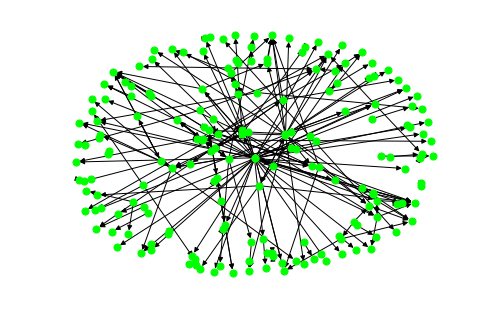

In [275]:
nx.draw_spring(g3, draw_labels=False, node_size=50, node_color='#00FF00')

As we can see, there are many nodes which are connected to exactly one other node, and a few nodes which are connected to a ton of other nodes. However, the graph looks like a mess and it is difficult to make any further observations easily because of the number of nodes and edges. It would be nice if there was a way to make this interactive. Fortunately, this is something that can be easily done and it is highly recommended that the reader go through the brilliant tutorial about making interactive graphs in NetworkX listed in [Further Reading and Resources](#last).

<a id='six'></a>
## 7. Conclusions
As we have seen, NetworkX is a powerful library for analyzing graphical data. Not only can we create graphs and run algorithms on them, but we can perform a lot of other useful things such as creating sample graphs, running graph operations, visualizing graphs and calculating the importance of different nodes in a graph. The Github GraphQL library is particularly useful for studying different aspects of NetworkX because not only is it a rich source of data, but everything is organized in the form of a graph anyway, which helps the user see how the data can be modeled as a graph. 

As a parting gift, the reader is encouraged to work on the following exercise: tweak the queries in order to obtain the favorite languages of users. Do users follow other users who have the same favorite programming language more often than following users with different favorite programming languages?

<a id='last'></a>
## 8. Further reading and Resources:

-  Graph generators and graph operations: https://networkx.github.io/documentation/stable/tutorial.html#graph-generators-and-graph-operations

-  Graph drawing functions and techniques: http://www.mhenderson.net/graph-drawing/2014/05/02/networkx-01.html

-  Different notions of centrality and their uses: https://en.wikipedia.org/wiki/Centrality

-  Github GraphQL API v4 basic usage: https://developer.github.com/v4/guides/forming-calls/

-  GraphQL Explorer for testing results of queries: https://developer.github.com/v4/explorer/

-  Making your graph interactive: https://www.alanzucconi.com/2015/11/01/interactive-graphs-in-the-browser/